In [1]:
import os
import glob
import tqdm
import scipy
import numpy as np
import pandas as pd
import nibabel as nb
import matplotlib.pyplot as plt

In [2]:
lana = pd.read_csv('../sessions/final_lang_atlas_sessions.csv')
coverage = pd.read_csv('../coverage/LanA_cerebellar_coverage.csv')

In [3]:
# construct cerebellar masks
nii = '../masks/Cerebellum-MNIsegment.nii'
nii = nb.load(nii)
vol = nii.get_fdata()
# construct binary mask for ROIs
left_cerebellum_mask = np.zeros(vol.shape, dtype=bool)
for i in [1,3,5,8,11,14,17,20,23,26]:
    mask_roi = (vol == i)
    left_cerebellum_mask = np.logical_or(left_cerebellum_mask, mask_roi)
right_cerebellum_mask = np.zeros(vol.shape, dtype=bool)
for i in [2,4,7,10,13,16,19,22,25,28]:
    mask_roi = (vol == i)
    right_cerebellum_mask = np.logical_or(right_cerebellum_mask, mask_roi)
left_cerebellum_mask = left_cerebellum_mask.flatten('C')
right_cerebellum_mask = right_cerebellum_mask.flatten('C')

# Lateralization in whole cerebellum vs cortex

In [6]:
# get total cerebellar and cortical sig S-N voxels, by hemisphere
threshold = 2.576 # p < 0.01 two-sided
n_sig_voxels = np.zeros((coverage.shape[0],4)) # LH cereb, RH cereb, LH cortex, RH cortex

files = glob.glob('../sessions/nii/*.nii')
for filename in tqdm.tqdm(files):
    session = filename.split('/')[-1].split('PL2017')[0]+'PL2017'
    idx = coverage.Session.tolist().index(session)
    if coverage.CerebellumVoxelsMissing[idx]>=50:
        n_sig_voxels[idx,:] = np.nan
        continue
    nii = nb.load(filename)
    vol = nii.get_fdata()
    # cerebellum total sig voxels
    n_sig_voxels[idx,0] = np.sum(vol.flatten('C')[left_cerebellum_mask]>threshold)
    n_sig_voxels[idx,1] = np.sum(vol.flatten('C')[right_cerebellum_mask]>threshold)
    # cortex total sig voxels
    n_sig_voxels[idx,2] = np.sum(vol[46:92,:,:]>threshold)-n_sig_voxels[idx,0]
    n_sig_voxels[idx,3] = np.sum(vol[0:46,:,:]>threshold)-n_sig_voxels[idx,1]

coverage['TotalSigVoxels_SN_LeftCerebellum'] = n_sig_voxels[:,0]
coverage['TotalSigVoxels_SN_RightCerebellum'] = n_sig_voxels[:,1]
coverage['TotalSigVoxels_SN_LeftCortex'] = n_sig_voxels[:,2]
coverage['TotalSigVoxels_SN_RightCortex'] = n_sig_voxels[:,3]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 806/806 [00:03<00:00, 205.50it/s]


In [7]:
for i,row in coverage.iterrows():
    print('%s :\t\t\tCEREBELLAR sig S-N voxels = %f LH, %f RH\t\t\tCORTICAL sig S-N voxels = %f LH, %f RH'%(row.Session,
                                                                                                    row.TotalSigVoxels_SN_LeftCerebellum,
                                                                                                    row.TotalSigVoxels_SN_RightCerebellum,
                                                                                                    row.TotalSigVoxels_SN_LeftCortex,
                                                                                                    row.TotalSigVoxels_SN_RightCortex))

001_SWJN_01_PL2017 :			CEREBELLAR sig S-N voxels = 4.000000 LH, 189.000000 RH			CORTICAL sig S-N voxels = 3904.000000 LH, 2082.000000 RH
002_SWJN_05_PL2017 :			CEREBELLAR sig S-N voxels = 88.000000 LH, 342.000000 RH			CORTICAL sig S-N voxels = 6589.000000 LH, 5160.000000 RH
003_SWJN_07_PL2017 :			CEREBELLAR sig S-N voxels = 36.000000 LH, 200.000000 RH			CORTICAL sig S-N voxels = 3316.000000 LH, 1310.000000 RH
004_SWJN_09_PL2017 :			CEREBELLAR sig S-N voxels = 547.000000 LH, 932.000000 RH			CORTICAL sig S-N voxels = 9958.000000 LH, 8412.000000 RH
005_SWJN_11_PL2017 :			CEREBELLAR sig S-N voxels = 526.000000 LH, 780.000000 RH			CORTICAL sig S-N voxels = 12337.000000 LH, 9481.000000 RH
006_SWJN_12_PL2017 :			CEREBELLAR sig S-N voxels = 918.000000 LH, 1525.000000 RH			CORTICAL sig S-N voxels = 9775.000000 LH, 6210.000000 RH
007_KAN_parametric_07_PL2017 :			CEREBELLAR sig S-N voxels = 27.000000 LH, 93.000000 RH			CORTICAL sig S-N voxels = 1486.000000 LH, 73.000000 RH
008_SWJNV2_01_PL2017 :	

In [8]:
for i,row in coverage.iterrows():
    if row.TotalSigVoxels_SN_LeftCerebellum+row.TotalSigVoxels_SN_RightCerebellum==0:
        print('%s\t no significant S-N CEREBELLAR voxels'%(row.Session))
    if row.TotalSigVoxels_SN_LeftCortex+row.TotalSigVoxels_SN_RightCortex==0:
        print('%s\t no significant S-N CORTICAL voxels'%(row.Session))

255_KAN_EvDB_20150223a_PL2017	 no significant S-N CEREBELLAR voxels
619_FED_20170613_3T2_PL2017	 no significant S-N CEREBELLAR voxels
798_POLY22_20191014a_3T2_PL2017	 no significant S-N CEREBELLAR voxels


In [9]:
for i,row in coverage.iterrows():
    if row.TotalSigVoxels_SN_LeftCerebellum==0:
        print('%s no significant LEFT cerebellar voxels'%(row.Session))
    if row.TotalSigVoxels_SN_RightCerebellum==0:
        print('%s no significant RIGHT cerebellar voxels'%(row.Session))

045_FED_20160817a_3T2_PL2017 no significant LEFT cerebellar voxels
064_KAN_langstroopBL_08_PL2017 no significant LEFT cerebellar voxels
078_KAN_langstroopBL_17_PL2017 no significant LEFT cerebellar voxels
097_KAN_RHnonlit_05_PL2017 no significant LEFT cerebellar voxels
106_KAN_domspec_18_PL2017 no significant LEFT cerebellar voxels
111_KAN_lingviol_08_PL2017 no significant LEFT cerebellar voxels
149_KAN_EvDB_20150501a_PL2017 no significant LEFT cerebellar voxels
184_KAN_locmvpa_12_PL2017 no significant LEFT cerebellar voxels
255_KAN_EvDB_20150223a_PL2017 no significant LEFT cerebellar voxels
255_KAN_EvDB_20150223a_PL2017 no significant RIGHT cerebellar voxels
267_KAN_EvDB_20150316a_PL2017 no significant LEFT cerebellar voxels
277_KAN_EvDB_20150325b_PL2017 no significant LEFT cerebellar voxels
281_KAN_EvDB_20150429e_PL2017 no significant LEFT cerebellar voxels
291_FED_20150615b_3T2_PL2017 no significant LEFT cerebellar voxels
302_FED_20150709a_3T2_PL2017 no significant LEFT cerebellar v

In [15]:
# compute lateralization
idxs = (coverage.Runs>=2) & (coverage.CerebellumVoxelsMissing<50) & ((coverage.TotalSigVoxels_SN_LeftCerebellum+coverage.TotalSigVoxels_SN_RightCerebellum)>0)
coverage_subset = coverage.loc[idxs]
lateralization = np.zeros((coverage_subset.shape[0],2))
lateralization[:,0] = (coverage_subset.TotalSigVoxels_SN_LeftCerebellum-coverage_subset.TotalSigVoxels_SN_RightCerebellum)/(coverage_subset.TotalSigVoxels_SN_LeftCerebellum+coverage_subset.TotalSigVoxels_SN_RightCerebellum) # cerebellum
lateralization[:,1] = (coverage_subset.TotalSigVoxels_SN_LeftCortex-coverage_subset.TotalSigVoxels_SN_RightCortex)/(coverage_subset.TotalSigVoxels_SN_LeftCortex+coverage_subset.TotalSigVoxels_SN_RightCortex) # cortex
lateralization_to_df = np.zeros((coverage.shape[0],2))
lateralization_to_df[:,:] = np.nan
lateralization_to_df[idxs,:] = lateralization
coverage['LateralizationCerebellum'] = lateralization_to_df[:,0]
coverage['LateralizationCortex'] = lateralization_to_df[:,1]
coverage.to_csv('LanA_lateralization.csv',index=False)

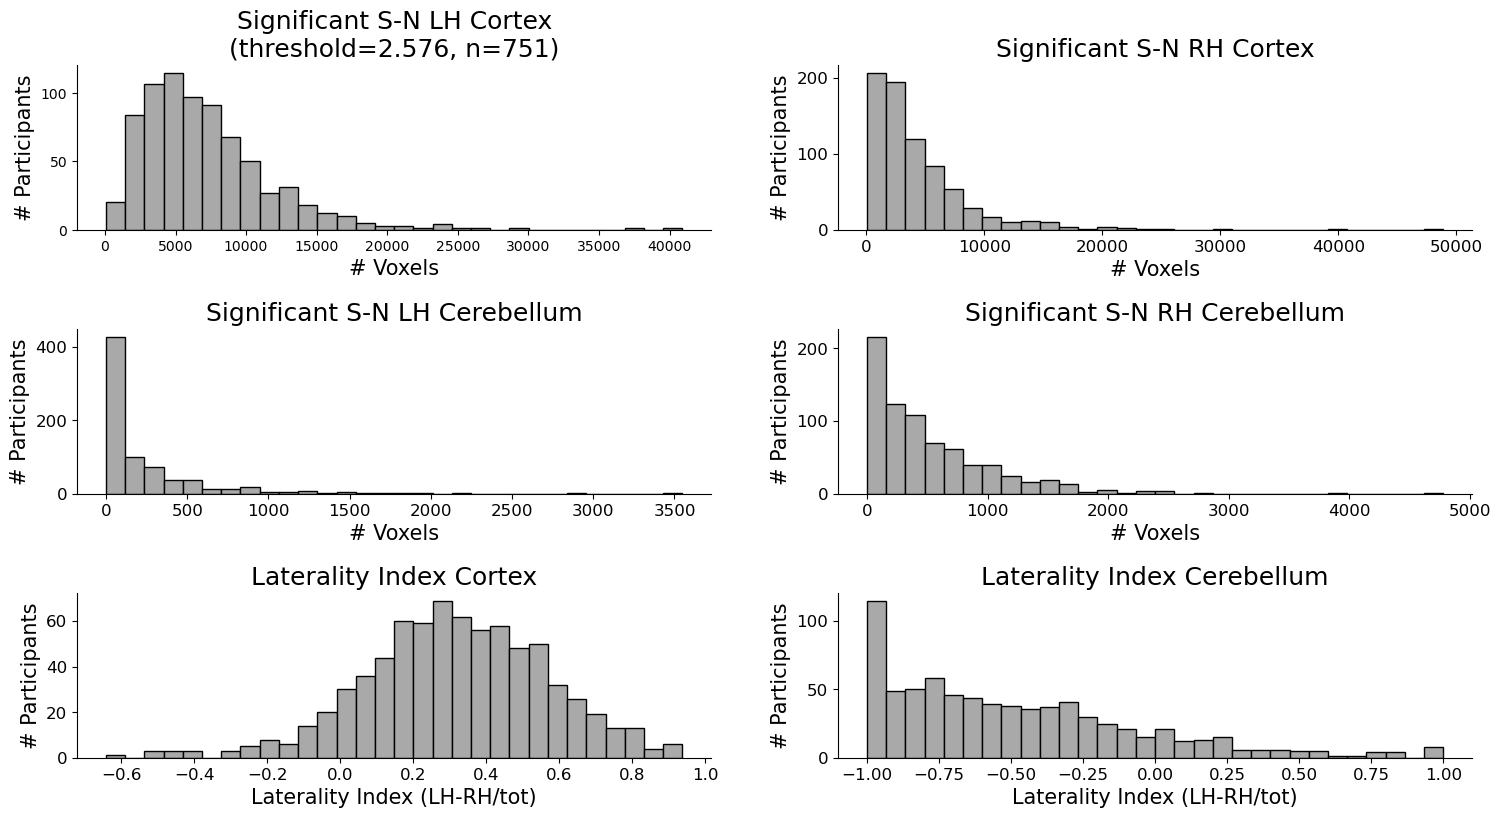

In [16]:
# plot 
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rc('font',**{'family':'sans-serif'})
plt.rc('pdf', **{'fonttype':42})
fig = plt.figure(figsize=(18,9))
fig.subplots_adjust(hspace=0.6, wspace=0.2)
style = {'facecolor': 'darkgrey', 'edgecolor': 'black', 'linewidth': 1}

ax = fig.add_subplot(3,2,1)
plt.hist(coverage_subset.TotalSigVoxels_SN_LeftCortex,30,**style)
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
ax.set_xlabel('# Voxels',fontsize=15)
ax.set_ylabel('# Participants',fontsize=15)
ax.set_title('Significant S-N LH Cortex\n(threshold='+str(threshold)+', n='+str(coverage_subset.shape[0])+')',fontsize=18)

ax = fig.add_subplot(3,2,2)
plt.hist(coverage_subset.TotalSigVoxels_SN_RightCortex,30,**style)
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
ax.set_xlabel('# Voxels',fontsize=15)
ax.set_ylabel('# Participants',fontsize=15)
ax.set_title('Significant S-N RH Cortex',fontsize=18)

ax = fig.add_subplot(3,2,3)
plt.hist(coverage_subset.TotalSigVoxels_SN_LeftCerebellum,30,**style)
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
ax.set_xlabel('# Voxels',fontsize=15)
ax.set_ylabel('# Participants',fontsize=15)
ax.set_title('Significant S-N LH Cerebellum',fontsize=18)

ax = fig.add_subplot(3,2,4)
plt.hist(coverage_subset.TotalSigVoxels_SN_RightCerebellum,30,**style)
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
ax.set_xlabel('# Voxels',fontsize=15)
ax.set_ylabel('# Participants',fontsize=15)
ax.set_title('Significant S-N RH Cerebellum',fontsize=18)

ax = fig.add_subplot(3,2,5)
plt.hist(lateralization[:,1],30,**style)
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
ax.set_xlabel('Laterality Index (LH-RH/tot)',fontsize=15)
ax.set_ylabel('# Participants',fontsize=15)
ax.set_title('Laterality Index Cortex',fontsize=18)

ax = fig.add_subplot(3,2,6)
plt.hist(lateralization[:,0],30,**style)
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
ax.set_xlabel('Laterality Index (LH-RH/tot)',fontsize=15)
ax.set_ylabel('# Participants',fontsize=15)
ax.set_title('Laterality Index Cerebellum',fontsize=18)

save_filename = 'lateralization_cortex_vs_cerebellum_histograms.pdf'
plt.savefig(save_filename,format='pdf',bbox_inches='tight',pad_inches=0.5) 

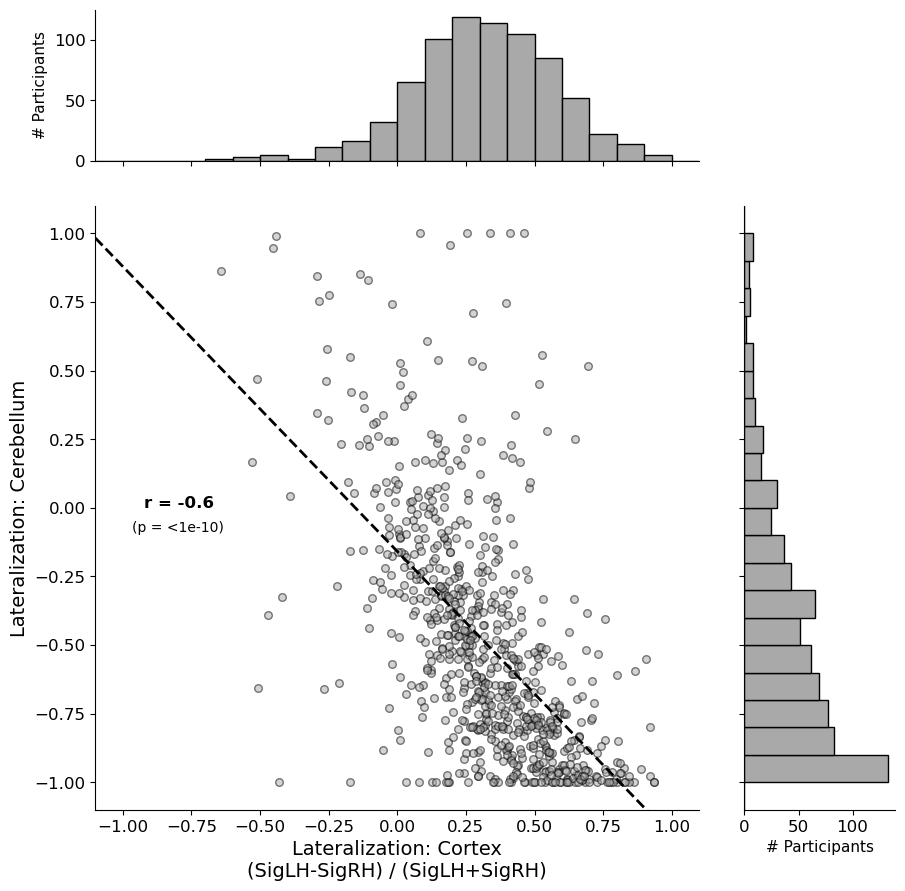

In [17]:
# scatter plot
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rc('font',**{'family':'sans-serif'})
plt.rc('pdf', **{'fonttype':42})

# from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
# Start with a square Figure.
fig = plt.figure(figsize=(10, 10))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.12, hspace=0.12)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
x = lateralization[:,1]
y = lateralization[:,0]

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# scatter plot:
ax.scatter(x, y, s=30, c='darkgrey', edgecolor='black', alpha=0.5)

# now determine nice limits by hand:
binwidth = 0.1
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth) + 1) * binwidth

# histogram
style = {'facecolor': 'darkgrey', 'edgecolor': 'black', 'linewidth': 1}
bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins, **style)
ax_histy.hist(y, bins=bins, orientation='horizontal', **style)
ax_histx.set_xlim([-1.1, 1.1])
ax_histy.set_ylim([-1.1, 1.1])
ax_histx.set_ylabel('# Participants',fontsize=11)
ax_histy.set_xlabel('# Participants',fontsize=11)

# dashed fit line
slope, intercept, r, p, _ = scipy.stats.linregress(x,y)
f = lambda a : slope*a + intercept
ax.set_xlim([-1.1, 1.1])
xlim = ax.get_xlim()
xvals = np.arange(xlim[0],xlim[1],0.001)
yvals = f(xvals)
ax.plot(xvals,yvals,'--k',linewidth=2)
        
# label plot with significance
if (p < 1e-10):
    p_string = '<1e-10'
    xshift = 0.06
else:
    p_string = "{:.3e}".format(p)
    xshift = 0.05
sig_label1 = 'r = ' + str(round(r,3))
sig_label2 = '(p = ' + p_string + ')'
ax.annotate(text=sig_label1,xy=(0.08,0.5),xycoords='axes fraction',fontsize=12,weight="heavy")
ax.annotate(text=sig_label2,xy=(xshift,0.46),xycoords='axes fraction',fontsize=10)

ax.set_xlabel('Lateralization: Cortex\n(SigLH-SigRH) / (SigLH+SigRH)',fontsize=14)
ax.set_ylabel('Lateralization: Cerebellum',fontsize=14)
ax.set_ylim([-1.1, 1.1])

# save
save_filename = 'lateralization_cortex_vs_cerebellum_scatter.pdf'
plt.savefig(save_filename,format='pdf',bbox_inches='tight',pad_inches=0.5) 